### Vertical Cross Section
https://wrf-python.readthedocs.io/en/latest/plot.html

https://www.nap.edu/read/1991/chapter/6
http://www.eumetrain.org/data/4/452/print_4.htm
https://www.weather.gov/btv/profileFroude
https://journals.ametsoc.org/doi/pdf/10.1175/1520-0434%282001%29016%3C0281%3AOOMWIP%3E2.0.CO%3B2
https://www.weather.gov/btv/froude
https://www.eoas.ubc.ca/courses/atsc113/flying/met_concepts/03-met_concepts/03d-mountain_waves/index.html
https://www.blogs.uni-mainz.de/fb08-ipa-en/bannerwolken/
https://www.sciencedirect.com/topics/earth-and-planetary-sciences/froude-number

In [1]:
import os, sys, datetime, string
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python/')
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python/MEPS/')
#sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/research_Haukeli/Python/WRF_python/src/')
#sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/research_Haukeli/Python/WRF_python/wrapt/src/wrapt')
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import simps

import createFolder as cF
#from matplotlib.cm import get_cmap
import matplotlib as mpl

import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from netCDF4 import Dataset
import pandas as pd

from metpy.interpolate import cross_section
from mpl_toolkits.basemap import Basemap, cm

import matplotlib.colors as colors

import gdal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cbook import get_sample_data
import pandas as pd
from matplotlib.colors import LightSource
from pyproj import Proj, transform

import fcts_read_stat as rs


In [2]:
station = 'Haukeliseter'
stn_lat = 59.81
stn_lon = 7.21

savefig = 1
if savefig == 1:
    figdir = '../../Figures/Norway_map/%s/MEPS' %(station)
    cF.createFolder('%s/' %figdir)
form = 'png'

In [3]:
thredds      = 'http://thredds.met.no/thredds/dodsC/meps25epsarchive'
#m = ['11', '12', '01', '02', '03']
m = ['12']
met_files = ['meps_mbr0_pp_2_5km_',
             'meps_subset_2_5km_',
             'meps_mbr0_full_backup_2_5km_'
            ]
forecasttime = '00'

In [4]:
Rd = 287.
cp=1.003*1000
g = 9.81


In [5]:
def find_station_yx(latitude, longitude, stn_lat, stn_lon):
# find the absolute value of the difference between the  station's lat/lon with every point in the grid. 
# This tells us how close a point is to the particular latitude and longitude.
    abslat = np.abs(latitude[:,:]-stn_lat)
    abslon = np.abs(longitude[:,:]-stn_lon)

# Now we need to combine these two results. We will use numpy.maximum, which takes two arrays and finds the local 
# maximum.
    c = np.maximum(abslon, abslat)

# If you don't like flattened arrays, you can also get the row/column index like this
    y, x = np.where(c == np.min(c))
    return(x,y);


In [6]:
def Lambert_map(lllon, lllat, urlon, urlat, lat0, lon0, res='l', fill=False, zoom=False):
    """lllon - lon lower left corner ...
    lat0 - latitude standard parallel, should be somewhere in the center of the domain
    lon0 - the parallel longitude
    lllon - lower left longitude ...
    http://matplotlib.org/basemap/api/basemap_api.html"""
    rsphere=(6378137.00,6356752.3142)
    map = Basemap(llcrnrlon=lllon, llcrnrlat=lllat, urcrnrlon=urlon, urcrnrlat=urlat, rsphere=rsphere,
            resolution=res,area_thresh=1000.,projection='lcc', lat_0=lat0,lon_0=lon0)
#    map = Basemap(llcrnrlon=lllon, llcrnrlat=lllat, urcrnrlon=urlon, urcrnrlat=urlat, rsphere=rsphere,
 #           resolution=res,area_thresh=1000.,projection='lcc', lat_1=lllon,lon_0=lon0)
    # Draw the latitudes and the longitudes
#    parallels = np.arange(0.,90,5.)
 #   map.drawparallels(parallels,labels=[True,False,False,False],fontsize=16)    
  #  meridians = np.arange(10.,361.,10.)
   # map.drawmeridians(meridians,labels=[False,False,False,True],fontsize=16)
    if zoom == False:
        map.drawmeridians(np.arange(0,90,10),labels=[0,0,0,1],fontsize=16)
        map.drawparallels(np.arange(10,361,4),labels=[1,0,0,0],fontsize=16)
    else:
#        map.drawmeridians(np.arange(0,90,3),labels=[0,0,0,1],fontsize=16)
 #       map.drawparallels(np.arange(0,361,2),labels=[1,0,0,0],fontsize=16)
        map.drawmeridians(np.arange(0,90,0.1),labels=[0,0,0,1],fontsize=16)
        map.drawparallels(np.arange(0,361,0.05),labels=[1,0,0,0],fontsize=16)

    # Draw the coastline
    map.drawcoastlines()#color='0.5')
    
    

    if fill:
        map.drawlsmask(#land_color='0.8', 
            ocean_color='gainsboro')
    
#    if zoom == False:
    
    ### plot MEPS area
 #       for i in range(0,lato.shape[0],12):
  #          xs, ys = map(lono[i], lato[i])
   #         map.plot(xs,ys, color = 'orange', marker = 'o', markersize = 10, linestyle = '-', linewidth = 10)
    #    for i in range(0,lato2.shape[0],12):
     #       xs2, ys2 = map(lono2[i], lato2[i])
      #      map.plot(xs2,ys2, color = 'orange', marker = 'o', markersize = 10, linestyle = '-', linewidth = 10)

       # xs, ys = map(lono[739], lato[739])
        #map.plot(xs,ys, color = 'orange', marker ='o', markersize = 10, linestyle = '-', linewidth = 10, label = 'MEPS domain')
        #lgd = plt.legend(loc='lower left',fontsize=18)

    #map.drawmapboundary(fill_color='gainsboro')
        
    return map    


In [7]:
def PlotContours(Lon, Lat, psurf, map, nrlevels=10, leveldist=None,levels=None, numbers=True, color= 'k'):
    """ contours for example the pressure
    nrlevels - gives the number of displayed levels
    leveldist - gives distance between levels, if specified the nlevels is ignored
    levels - can be an array that specifies the levels to display, if specified nrlevels and leveldist are ignored
    numbers - True if the contours are labeled
    color - color of the contours (None is s color map)"""
    if levels is not None:
        cs= map.contour(Lon, Lat, psurf, levels, linewidths= 1. , colors= color)
    elif leveldist is not None:
        levels= np.arange(np.round(np.min(psurf)- np.min(psurf)%leveldist), np.round(np.max(psurf)+ leveldist), leveldist)
        cs= map.contour(Lon, Lat, psurf, levels, linewidths= 1. , colors= color)        
    else:
        cs= map.contour(Lon, Lat, psurf, nrlevels, linewidths= 1. , colors= color)#, colors= 6*['b']+ 6*['r'],)
    if numbers == True: plt.clabel(cs, fontsize=10, inline=1, fmt='%1.0f', color= 'black')
    #plt.tight_layout()

In [8]:
mpl.style.use('seaborn')
nice_fonts = {
        # Use LaTex to write all text
        "text.usetex": True,
#        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 14,
        "font.size": 14,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
}
#plt.rcParams.update({'font.size': 14})
mpl.rcParams.update(nice_fonts)


In [9]:
def plt_Norway_map_crosssection(stn_lon, stn_lat, longitude, latitude, alti,
                               longi, lati, yy2, xx2):
    
    ### Norway ###
    #plt.figure(1)
    fig = plt.figure(figsize=(9,8))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    #map = Lambert_map(lllon=0., lllat=49., urlon=50., urlat=72, lat0= 63.5, lon0= 15, res='l', fill=True,zoom=False)
    #map = Lambert_map(lllon=longitude[0,:].min(), lllat=latitude[0,:].min(), 
     #                urlon=longitude[-1,:].max(), urlat=latitude[-1,:].max(), 
      #               lat0= 63.5, lon0= 15, res='l', fill=True,zoom=False)
    map = Lambert_map(lllon=stn_lon-0.41, lllat=stn_lat-0.11, 
                      urlon=stn_lon+0.3, urlat=stn_lat+0.2, 
                      lat0= stn_lat, lon0= stn_lon, res='l', fill=True,zoom=True)

    Lonpp,Latpp = map(longitude,latitude)
    #alti[alti<3] = np.nan
    #PlotContours(Lonpp, Latpp, alti, map, leveldist=None,levels=[0, 25, 50, 100, 200, 300, 400, 500, 600,1000,1500,2000], numbers=True, color= 'k')
    #PlotColorMap4(Lonpp, Latpp, alti, map, bounds= [3, 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1250, 1500,],color='red', label='Altitude')

    levels = np.arange(0,np.nanmax(alti),50)
    norm = colors.BoundaryNorm(boundaries = levels, ncolors=plt.cm.gist_earth.N)

    #cs = map.contourf(Lonpp, Latpp, alti, levels, norm=norm, cmap = plt.cm.gist_earth, extend='max')
    cs = map.pcolormesh(Lonpp, Latpp, alti,cmap=plt.cm.gist_earth)
    cb = plt.colorbar(cs, boundaries= levels, #location='right',
                      extend='max')
    cb.set_label('Altitude [m]', size=18)    
    cb.ax.tick_params(labelsize=16)
    plt.gca().set_aspect('equal', adjustable='box')

    #levels = np.arange(700,1800,50)
    PlotContours(Lonpp, Latpp, alti, map, leveldist=None, levels=levels, numbers=True,color='gray')

    namestat = ['Haukeliseter']
#    lonstat = [7+12.87/60]#,7.2]
 #   latstat= [59+48.73/60]#,59.8]
    lonstat = [stn_lon]#,7.2]
    latstat= [stn_lat]#,59.8]



    xpt, ypt= map(lonstat, latstat)
    map.plot(xpt,ypt,'ko')
    for i in range(len(namestat)):
        plt.text(xpt[i]+100, ypt[i]+100, namestat[i], fontsize=18,fontweight='bold', 
                 ha='center',va='bottom',color='black')
    #plt.tight_layout(pad=2.5)  


    #x4, y4 = map(longitude[309,(np.array(xx)[~np.isnan(xx)]).astype(int)],
     #            latitude[309,(np.array(xx)[~np.isnan(xx)]).astype(int)])
    #map.scatter(x4,y4)
    #for i, (xl,yl) in enumerate(zip(x4, y4), start=1):
     #   ax.annotate(str(i), (xl,yl), xytext=(5,5), textcoords='offset points',fontsize=14)

    #x5, y5 = map(longitude[310,(np.array(xx)[~np.isnan(xx)]).astype(int)],
     #            latitude[310,(np.array(xx)[~np.isnan(xx)]).astype(int)])
    #map.scatter(x5,y5)
    #for i, (xl,yl) in enumerate(zip(x5, y5), start=1):
     #   ax.annotate(str(i), (xl,yl), xytext=(5,5), textcoords='offset points',fontsize=14)


    #x6, y6 = map(longitude[311,(np.array(xx)[~np.isnan(xx)]).astype(int)],
     #            latitude[311,(np.array(xx)[~np.isnan(xx)]).astype(int)])
    #map.scatter(x6,y6)
    #for i, (xl,yl) in enumerate(zip(x6, y6), start=1):
     #   ax.annotate(str(i), (xl,yl), xytext=(5,5), textcoords='offset points',fontsize=14)


    ###############################    
    x4, y4 = map(longi[np.min(yy2)-1,(np.array(xx2)[~np.isnan(xx2)]).astype(int)],
                 lati[np.min(yy2)-1,(np.array(xx2)[~np.isnan(xx2)]).astype(int)])
    map.scatter(x4,y4, c = 'darkblue')
    for i, (xl,yl) in enumerate(zip(x4, y4), start=1):
        ax.annotate(str(i), (xl,yl), xytext=(5,5), textcoords='offset points',fontsize=14)
    ###############################
    x5, y5 = map(longi[np.min(yy2),(np.array(xx2)[~np.isnan(xx2)]).astype(int)],
                 lati[np.min(yy2),(np.array(xx2)[~np.isnan(xx2)]).astype(int)])
    map.scatter(x5,y5, c = 'goldenrod')
    for i, (xl,yl) in enumerate(zip(x5, y5), start=1):
        ax.annotate(str(i), (xl,yl), xytext=(5,5), textcoords='offset points',fontsize=14)

    ###############################    
    x6, y6 = map(longi[np.max(yy2)-1,(np.array(xx2)[~np.isnan(xx2)]).astype(int)],
                 lati[np.max(yy2)-1,(np.array(xx2)[~np.isnan(xx2)]).astype(int)])
    map.scatter(x6,y6, c = 'mediumorchid')
    for i, (xl,yl) in enumerate(zip(x6, y6), start=1):
        ax.annotate(str(i), (xl,yl), xytext=(5,5), textcoords='offset points',fontsize=14)
    ###############################    
    x6, y6 = map(longi[np.max(yy2),(np.array(xx2)[~np.isnan(xx2)]).astype(int)],
                 lati[np.max(yy2),(np.array(xx2)[~np.isnan(xx2)]).astype(int)])
    map.scatter(x6,y6,c = 'indianred')
    for i, (xl,yl) in enumerate(zip(x6, y6), start=1):
        ax.annotate(str(i), (xl,yl), xytext=(5,5), textcoords='offset points',fontsize=14)

In [10]:
def get_potential_temperature_diff(pot_temp_ml):
    diff_pot_temp = []
    for i in range(pot_temp_ml.shape[1]-1):
        dpot = pot_temp_ml[:,i+1] - pot_temp_ml[:,i]
        diff_pot_temp.append(dpot)
    diff_pot_temp = np.array(diff_pot_temp)

    diff_pot_temp = np.transpose(diff_pot_temp)
    
    return(diff_pot_temp)

In [11]:
def get_heigth_in_ml(dz):
    
    h_above = []
    h_above.append(np.zeros(dz[:,:].shape[0]))
    th_arr = np.nansum([np.asarray(h_above)[:,0], dz[:,0]],axis=0)
    h_above.append(th_arr)
    for i in range(2, dz.shape[1]):
        th_arr = np.nansum([np.array(h_above)[i-1,:], dz[:,i-1]], axis=0)
        h_above.append(th_arr)
    height_ml = np.transpose(h_above)
    
    return(height_ml)

In [12]:
def plt_froude_number(longi, lati, yy2, xx2, elevation, Fr,
                     longitude, yy,xx):
    fig, (ax0, ax1,ax2,ax3 ) = plt.subplots(nrows=4,sharex=True, sharey=True)
    fig.set_figheight(10)
    fig.set_figwidth(10)

    norm = mpl.colors.Normalize(vmin=1,vmax=18)

    #############################################
    im = ax0.contourf(np.array([longi[np.min(yy2)-1,(np.array(xx2)[~np.isnan(xx2)]).astype(int)],]* elevation.shape[1]),
                     elevation[0,:,0,:], 
                     Fr[0,:,0,:], 
                     cmap = plt.get_cmap('rainbow'), norm=norm,
                     levels=(np.arange(0.25,15.5,0.5)), vmin=0.25,vmax=15.,
                    extend='max', 
                     )

    CS = ax0.contour(np.array([longi[np.min(yy2)-1,(np.array(xx2)[~np.isnan(xx2)]).astype(int)],]* elevation.shape[1]),
                     elevation[0,:,0,:], 
                     Fr[0,:,0,:], 
                     colors = 'k', linestyle=('-'), #linewidths=(2,),
                     levels=[1.],
                 #    extend='both')
                )

    ax0.set_ylim([np.round(elevation.min())-20,1600])
    ax0.set_xlim([longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].min(),
              longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].max()])
    cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, extend='both',ticks=np.array([0.5,1.,7.,15.]))
    cbar.set_label('Froud number')

    ax0.fill_between(longitude[np.min(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     alti[np.min(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     facecolor = 'darkgrey')
    ax0.vlines(7.21,0,5000)


    #############################################
    im = ax1.contourf(np.array([longi[np.min(yy2),(np.array(xx2)[~np.isnan(xx2)]).astype(int)],]* elevation.shape[1]),
                     elevation[0,:,1,:], 
                     Fr[0,:,1,:], 
                     cmap = plt.get_cmap('rainbow'), norm=norm,
                     levels=(np.arange(0.25,15.5,0.5)), vmin=0.25,vmax=15.,
                    extend='max', 
                     )

    CS = ax1.contour(np.array([longi[np.min(yy2),(np.array(xx2)[~np.isnan(xx2)]).astype(int)],]* elevation.shape[1]),
                     elevation[0,:,1,:], 
                     Fr[0,:,1,:], 
                     colors = 'k', linestyle=('-'), #linewidths=(2,),
                     levels=[1.],
                     extend='both')


    ax1.set_ylim([np.round(elevation.min())-20,1600])
    #cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
    #cbar = fig.colorbar(im, ax=ax1, extend='both',ticks=np.array([0.5,1.,7.,15.]))
    #cbar.set_label('U [ms$^{-1}$]')

    ax1.fill_between(longitude[np.min(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     alti[np.min(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     facecolor = 'darkgrey')
    ax1.vlines(7.21,0,5000)

    #############################################
    im = ax2.contourf(np.array([longi[np.max(yy2)-1,(np.array(xx2)[~np.isnan(xx2)]).astype(int)],]* elevation.shape[1]),
                     elevation[0,:,2,:], 
                     Fr[0,:,2,:], 
                     cmap = plt.get_cmap('rainbow'), norm=norm,
                     levels=(np.arange(0.25,15.5,0.5)), vmin=0.25,vmax=15.,
                    extend='max', 
                     )

    CS = ax2.contour(np.array([longi[np.max(yy2)-1,(np.array(xx2)[~np.isnan(xx2)]).astype(int)],]* elevation.shape[1]),
                     elevation[0,:,2,:], 
                     Fr[0,:,2,:], 
                     colors = 'k', linestyle=('-'), #linewidths=(2,),
                     levels=[1.],
                 #    extend='both')
                )
    #ax2.set_ylim([np.round(elevation.min())-20,2000])
    #cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
    #cbar = fig.colorbar(im, ax=ax2, extend='both',ticks=np.array([0.5,1.,7.,15.]))
    #cbar.set_label('U [ms$^{-1}$]')

    ax2.fill_between(longitude[np.max(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     alti[np.max(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     facecolor = 'darkgrey')
    ax2.vlines(7.21,0,5000)

    #############################################
    im = ax3.contourf(np.array([longi[np.max(yy2),(np.array(xx2)[~np.isnan(xx2)]).astype(int)],]* elevation.shape[1]),
                     elevation[0,:,3,:], 
                     Fr[0,:,3,:], 
                     cmap = plt.get_cmap('rainbow'), norm=norm,
                     levels=(np.arange(0.25,15.5,0.5)), vmin=0.25,vmax=15.,
                    extend='max', 
                     )

    CS = ax3.contour(np.array([longi[np.max(yy2)-1,(np.array(xx2)[~np.isnan(xx2)]).astype(int)],]* elevation.shape[1]),
                     elevation[0,:,3,:], 
                     Fr[0,:,3,:], 
                     colors = 'k', linestyle=('-'), #linewidths=(2,),
                     levels=[1.],
                 #    extend='both')
                )
    #ax3.set_ylim([np.round(elevation.min())-20,2000])
    #cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
    #cbar = fig.colorbar(im, ax=ax3, extend='both',ticks=np.array([0.5,1.,7.,15.]))
    #cbar.set_label('U [ms$^{-1}$]')

    ax3.fill_between(longitude[np.max(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     alti[np.max(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     facecolor = 'darkgrey')
    ax3.vlines(7.21,0,5000)


In [13]:
def plt_hzwind_pottemp(pot_temp_ml, longi, yy2, xx2, elevation, U, longitude, yy, xx):

    norm = mpl.colors.Normalize(vmin=20,vmax=46)

    fig, (ax0, ax1,ax2,ax3 ) = plt.subplots(nrows=4,sharex=True, sharey=True)
    fig.set_figheight(10)
    fig.set_figwidth(10)

    levels = np.arange(np.round(pot_temp_ml[0,np.where(elevation[0,:,:,:] < 2000),:,:].min()), 278.2, 0.4)

    im = ax0.contourf(np.array([longi[np.min(yy2)-1,(np.array(xx2)[~np.isnan(xx2)]).astype(int)],]* elevation.shape[1]),
                     elevation[0,:,0,:], 
                     U[0,:,0,:], 
                     cmap = plt.get_cmap('rainbow'), norm=norm,
                     levels=(np.arange(20,46,0.5)),
                     extend='both')
    CS = ax0.contour(np.array([longitude[np.min(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)],]* elevation.shape[1]),
                     elevation[0,:,0,:], 
                     pot_temp_ml[0,:-1,0,:],
                     levels = levels,
                     colors='k',)

    ax0.clabel(CS, inline=1,fmt='%1.1f')
    lines= [CS.collections[0]]
    labels=['$\Theta$ [K]']
    ax0.legend(lines,labels,  loc='lower right',fancybox=True, facecolor ='white', frameon=True, framealpha=0.9)
    #ax0.contour(np.array([longitude[np.min(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)],]* elevation.shape[1]),
     #                 elevation[0,:,0,:], 
      #                upward_air_velocity_ml[0,:,0,:],
       #        levels=np.arange(-1.2,2.1,0.1), colors = 'b' )
    ax0.set_ylim([np.round(elevation.min())-20,2000])
    ax0.set_xlim([longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].min(),
                  longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].max()])
    cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, extend='both',ticks=np.arange(20,50,2))
    cbar.set_label('U [ms$^{-1}$]')

    ax0.fill_between(longitude[np.min(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     alti[np.min(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     facecolor = 'darkgrey')
    ax0.vlines(7.21,0,5000)

    ###################################################
    im = ax1.contourf(np.array([longi[np.min(yy2),(np.array(xx2)[~np.isnan(xx2)]).astype(int)],]* elevation.shape[1]),
                     elevation[0,:,1,:], 
                     U[0,:,1,:], 
                     cmap = plt.get_cmap('rainbow'), norm=norm,
                     levels=(np.arange(20,46,0.5)),
                     extend='both')
    CS = ax1.contour(np.array([longitude[np.min(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)],]* elevation.shape[1]),
                     elevation[0,:,1,:], 
                     pot_temp_ml[0,:-1,1,:],
                     levels = levels,
                     colors='k')

    ax1.clabel(CS, inline=1,fmt='%1.1f')
    lines= [CS.collections[0]]
    labels=['$\Theta$ [K]']
    ax1.legend(lines,labels,  loc='lower right',fancybox=True, facecolor ='white', frameon=True, framealpha=0.9)

    #ax1.contour(np.array([longitude[np.min(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)],]* elevation.shape[1]),
     #                 elevation[0,:,1,:], 
      #                upward_air_velocity_ml[0,:,1,:],
       #        levels=np.arange(-1.2,2.1,0.1), colors = 'b' )
    ax1.set_ylim([np.round(elevation.min())-20,2000])
    ax1.set_xlim([longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].min(),
                  longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].max()])
    ax1.fill_between(longitude[np.min(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     alti[np.min(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     facecolor = 'darkgrey')
    ax1.vlines(7.21,0,5000)

    ###################################################
    im = ax2.contourf(np.array([longi[np.max(yy2)-1,(np.array(xx2)[~np.isnan(xx2)]).astype(int)],]* elevation.shape[1]),
                     elevation[0,:,2,:], 
                     U[0,:,2,:], 
                     cmap = plt.get_cmap('rainbow'), norm=norm,
                     levels=(np.arange(20,46,0.5)),
                     extend='both')
    CS = ax2.contour(np.array([longitude[np.max(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)],]* elevation.shape[1]),
                     elevation[0,:,2,:], 
                     pot_temp_ml[0,:-1,2,:],
                     levels = levels,
                     colors='k')
    ax2.clabel(CS, inline=1,fmt='%1.1f')
    lines= [CS.collections[0]]
    labels=['$\Theta$ [K]']
    ax2.legend(lines,labels,  loc='lower right',fancybox=True, facecolor ='white', frameon=True, framealpha=0.9)

    #ax2.contour(np.array([longitude[np.max(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)],]* elevation.shape[1]),
     #                 elevation[0,:,2,:], 
      #                upward_air_velocity_ml[0,:,2,:],
       #        levels=np.arange(-1.2,2.1,0.1), colors = 'b' )
    ax2.set_ylim([np.round(elevation.min())-20,2000])
    ax2.set_xlim([longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].min(),
                  longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].max()])
    ax2.fill_between(longitude[np.max(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     alti[np.max(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     facecolor = 'darkgrey')
    ax2.vlines(7.21,0,5000)

    ###################################################
    im = ax3.contourf(np.array([longi[np.max(yy2),(np.array(xx2)[~np.isnan(xx2)]).astype(int)],]* elevation.shape[1]),
                     elevation[0,:,3,:], 
                     U[0,:,3,:], 
                     cmap = plt.get_cmap('rainbow'), norm=norm,
                     levels=(np.arange(20,46,0.5)),
                     extend='both')
    CS = ax3.contour(np.array([longitude[np.max(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)],]* elevation.shape[1]),
                     elevation[0,:,3,:], 
                     pot_temp_ml[0,:-1,3,:],
                     levels = levels,
                     colors='k')

    ax3.clabel(CS, inline=1,fmt='%1.1f')
    lines= [CS.collections[0]]
    labels=['$\Theta$ [K]']
    ax3.legend(lines,labels,  loc='lower right',fancybox=True, facecolor ='white', frameon=True, framealpha=0.9)

    #ax3.contour(np.array([longitude[np.max(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)],]* elevation.shape[1]),
     #                 elevation[0,:,2,:], 
      #                upward_air_velocity_ml[0,:,2,:],
       #        levels=np.arange(-1.2,2.1,0.1), colors = 'b' )
    ax3.set_ylim([np.round(elevation.min())-20,3000])
    ax3.set_xlim([longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].min(),
                  longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].max()])
    ax3.fill_between(longitude[np.max(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     alti[np.max(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     facecolor = 'darkgrey')
    ax3.vlines(7.21,0,5000)

In [14]:
def plt_vertical_wind(longitude, yy, xx, elevation, upward_air_velocity_ml):

    cmap = plt.get_cmap('RdBu')
    norm = mpl.colors.Normalize(vmin=-1.,vmax=1.)


    fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4,sharex=True, sharey=True)
    fig.set_figheight(10)
    fig.set_figwidth(10)

    ###################################
    im = ax0.contourf(np.array([longitude[np.min(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)],]* elevation.shape[1]),
                      elevation[0,:,0,:], 
                      upward_air_velocity_ml[0,:,0,:],
                      cmap=cmap,
                      norm=norm,
                      levels=np.arange(-1.,1.,0.01),  
                      extend='both')
    #fig.colorbar(im,ax=ax0,extend='both',ticks=np.arange(-1.2,2.1,0.4))
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, extend='both',ticks=np.arange(-2.,2.1,0.4))
    cbar.set_label('V [ms$^{-1}$]')

    ax0.fill_between(longitude[np.min(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     alti[np.min(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     facecolor = 'darkgrey')

    ax0.set_ylim([np.round(elevation.min())-20,2000])
    ax0.set_xlim([longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].min(),
                  longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].max()])
    ax0.vlines(7.21,0,5000)
    ###################################
    im = ax1.contourf(np.array([longitude[np.min(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)],]* elevation.shape[1]),
                      elevation[0,:,1,:], 
                      upward_air_velocity_ml[0,:,1,:],
                      cmap=cmap,norm=norm,
                      levels=np.arange(-1.,1.,0.01),  
                      extend='both')
    #fig.colorbar(im,ax=ax1,extend='both')#,ticks=np.arange(-2.,2.1,0.4))
    ax1.fill_between(longitude[np.min(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     alti[np.min(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     facecolor = 'darkgrey')

    ax1.set_ylim([np.round(elevation.min())-20,2000])
    ax1.set_xlim([longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].min(),
                  longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].max()])
    ax1.vlines(7.21,0,5000)
    ###################################
    im = ax2.contourf(np.array([longitude[np.max(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)],]* elevation.shape[1]),
                      elevation[0,:,2,:], 
                      upward_air_velocity_ml[0,:,2,:],
                      cmap=cmap,norm=norm,
                      levels=np.arange(-1.,1.,0.01),  
                      extend='both')
    #fig.colorbar(im,ax=ax2,extend='both')#,ticks=np.arange(-2.,2.1,0.4))
    ax2.fill_between(longitude[np.max(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     alti[np.max(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     facecolor = 'darkgrey')

    ax2.set_ylim([np.round(elevation.min())-20,2000])
    ax2.set_xlim([longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].min(),
                  longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].max()])
    ax2.vlines(7.21,0,5000)

    ###################################
    im = ax3.contourf(np.array([longitude[np.max(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)],]* elevation.shape[1]),
                      elevation[0,:,3,:], 
                      upward_air_velocity_ml[0,:,3,:],
                      cmap=cmap,norm=norm,
                      levels=np.arange(-1.,1.,0.01),  
                      extend='both')
    #fig.colorbar(im,ax=ax3,extend='both')#,ticks=np.arange(-2.,2.1,0.4))
    ax3.fill_between(longitude[np.max(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     alti[np.max(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)], 
                     facecolor = 'darkgrey')

    ax3.set_ylim([np.round(elevation.min())-20,2000])
    ax3.set_xlim([longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].min(),
                  longitude[(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].max()])
    ax3.vlines(7.21,0,5000)

RuntimeError: NetCDF: Not a valid ID

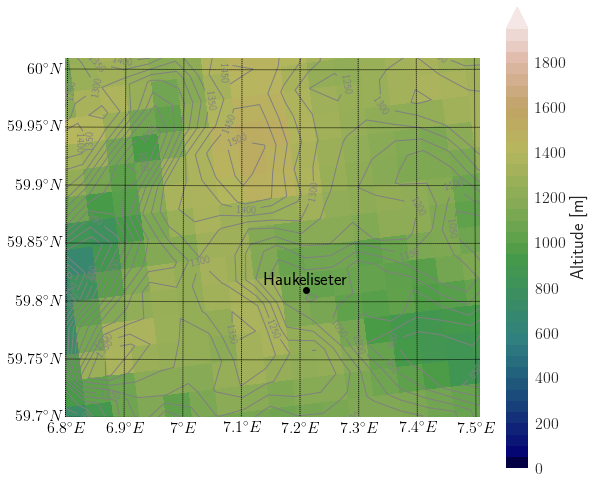

In [15]:
for month in m:
    if month == '11':
        t = np.arange(7,31)
    if month == '12':# or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

# Open the NetCDF file with altitude
        Dataframe = Dataset('%s/%s/%s/%s/%s%s%s%sT%sZ.nc' %(thredds,year,month,day,met_files[0],year,month,day,forecasttime),
                                 'r')

        alti= Dataframe.variables['altitude'][:]

        ## Latitudes
        ## [y = 949][x = 739]
        latitude = Dataframe.variables['latitude'][:]

        ## Longitudes 
        ## [y = 949][x = 739]
        longitude = Dataframe.variables['longitude'][:]

        Dataframe.close()

    #    x, y = find_station_yx(latitude, longitude, stn_lat, stn_lon)

        lon = np.array(np.arange(6.85,7.45,0.01))

        xx = []
        yy = []
        for i in range(lon.shape[0]):
            x, y = find_station_yx(latitude, longitude, stn_lat, lon[i])
            xx.append(x)
            yy.append(y)


        for i in range(lon.shape[0]-1):
            if xx[i] == xx[i+1]:
                #print(i, xx[i], xx[i+1])
                xx[i] = np.nan

        # Open the NetCDF file with vertical values
        fn = dict()
        for i in range(1,np.shape(met_files)[0]):
            fn[i] = Dataset('%s/%s/%s/%s/%s%s%s%sT%sZ.nc' %(thredds,year,month,day,met_files[i],year,month,day,forecasttime),
                                         'r')
        #fn

        ## Latitudes
        ## [y = 949][x = 739]
        lati = fn[2].variables['latitude']

        ## Longitudes 
        ## [y = 949][x = 739]
        longi = fn[2].variables['longitude']

        # Now find the absolute value of the difference between the  station's lat/lon with every point in the grid. 
        x,y = rs.find_station_yx(lati, longi, stn_lat, stn_lon)
        y = y[0]
        x = x[0]

        xx2 = []
        yy2 = []
        for i in range(lon.shape[0]):
            x2, y2 = find_station_yx(lati, longi, stn_lat, lon[i])
            xx2.append(x2)
            yy2.append(y2)

        for i in range(lon.shape[0]-1):
            if xx2[i] == xx2[i+1]:
                #print(i, xx[i], xx[i+1])
                xx2[i] = np.nan

########################################
        ######## with Vertical Levels ( hybrid )#################################
        ## hybrid levels atmosphere_hybrid_sigma_pressure_coordinate
        # formula: p(n,k,j,i) = ap(k) + b(k)*ps(n,j,i)
        # positive: down


        ### variables to calculate pressure
        #p0 = fn.variables['p0']    ## p0: p0

        ap = fn[2].variables['ap'][:]    ## ap: ap
        b = fn[2].variables['b'] [:]     ## b: b


        surface_air_pressure = fn[1].variables['surface_air_pressure'][:,:,0,np.min(yy2)-1 : np.max(yy2)+1 ,
                                                                       (np.array(xx2)[~np.isnan(xx2)]).astype(int)]
        air_temperature_0m   = fn[1].variables['air_temperature_0m'][:,:,0,np.min(yy2)-1 : np.max(yy2)+1,
                                                                     (np.array(xx2)[~np.isnan(xx2)]).astype(int)]
        air_temperature_ml   = fn[2].variables['air_temperature_ml'][:,:,0,np.min(yy2)-1 : np.max(yy2)+1,
                                                                     (np.array(xx2)[~np.isnan(xx2)]).astype(int)]



        upward_air_velocity_ml         = fn[2].variables['upward_air_velocity_ml'][:,:,0,np.min(yy2)-1 : np.max(yy2)+1,
                                                                                   (np.array(xx2)[~np.isnan(xx2)]).astype(int)]
        height2                        = fn[2].variables['height2'][:]
        brunt_vaisala_frequency_in_air = fn[2].variables['brunt_vaisala_frequency_in_air'][:,:,0,np.min(yy2)-1 : np.max(yy2)+1,
                                                                                           (np.array(xx2)[~np.isnan(xx2)]).astype(int)]

        
        x_wind_ml = fn[2].variables['x_wind_ml'][:,:,0,np.min(yy2)-1 : np.max(yy2)+1,
                                                                                   (np.array(xx2)[~np.isnan(xx2)]).astype(int)]
        y_wind_ml = fn[2].variables['y_wind_ml'][:,:,0,np.min(yy2)-1 : np.max(yy2)+1,
                                                                                   (np.array(xx2)[~np.isnan(xx2)]).astype(int)]
        
        for i in range(1,np.shape(met_files)[0]):
            fn[i].close()
########################################################

        ### Transfer pressure coordinate
        p_interface = np.empty(shape = (surface_air_pressure.shape[0],
                                        ap.shape[0],
                                        surface_air_pressure.shape[2],
                                        surface_air_pressure.shape[3]) )
        p_interface[:] = np.nan

        p_interfaces2 = np.empty(shape = (surface_air_pressure.shape[0],
                                        ap.shape[0]+1,
                                        surface_air_pressure.shape[2],
                                        surface_air_pressure.shape[3]) )
        p_interfaces2[:] = np.nan

        p_ml = np.empty(shape = (surface_air_pressure.shape[0],
                                        ap.shape[0],
                                        surface_air_pressure.shape[2],
                                        surface_air_pressure.shape[3]))
        p_ml[:] = np.nan

        p_ml2 = np.empty(shape = (surface_air_pressure.shape[0],
                                        ap.shape[0]+1,
                                        surface_air_pressure.shape[2],
                                        surface_air_pressure.shape[3]))
        p_ml2[:] = np.nan

        temperature_ml = np.empty(shape = (surface_air_pressure.shape[0],
                                        ap.shape[0]+1,
                                        surface_air_pressure.shape[2],
                                        surface_air_pressure.shape[3]))
        temperature_ml[:] = np.nan

        dz = np.empty(shape = (surface_air_pressure.shape[0],
                                        ap.shape[0],
                                        surface_air_pressure.shape[2],
                                        surface_air_pressure.shape[3]))
        dz[:] = np.nan

        dgeop = np.empty(shape = (surface_air_pressure.shape[0],
                                        ap.shape[0],
                                        surface_air_pressure.shape[2],
                                        surface_air_pressure.shape[3]))
        dgeop[:] = np.nan
        #for k,l in zip( range(surface_air_pressure.shape[2]), range(surface_air_pressure.shape[3])):
        for k in range(surface_air_pressure.shape[2]):
            for l in range(surface_air_pressure.shape[3]):
                p_interface[:,:,k,l] = ap[:]+b[:]*surface_air_pressure[:,:,k,l]


            ### 1) Connect interface values and surface values for pressure
            ### Pressure
                p_interfaces2[:,:,k,l] = np.concatenate((p_interface[:,:,k,l],surface_air_pressure[:,:,k,l]),axis=1)

            # transform hybrid sigma pressure coordinates at interface levels to pressure at model levels

                for i in range(0,p_interfaces2.shape[1]-1):
                    p_ml[:,i,k,l] = 1/2 * (p_interfaces2[:,i,k,l] + p_interfaces2[:,i+1,k,l])
                p_ml2[:,:,k,l] = np.concatenate((p_ml[:,:,k,l],surface_air_pressure[:,:,k,l]),axis=1)

            ### --> Now the pressure is calculated at each model level

            ### 2) Connect model levels and surface values for temperature
            ### Temperature
                temperature_ml[:,:,k,l] = np.concatenate((air_temperature_ml[:,:,k,l],
                                                        air_temperature_0m[:,:,k,l]),axis=1)

                dz[:,:,k,l], dgeop[:,:,k,l] = rs.get_thickness(p_ml2[:,:,k,l], temperature_ml[:,:,k,l])
                
        ################################################    
        ### plot cross sections on Haukeliseter map
        plt_Norway_map_crosssection(stn_lon, stn_lat, longitude, latitude, alti,
                                       longi, lati, yy2, xx2)

        if savefig == 1:
            cF.createFolder('%s/cross_section/' %(figdir))
            #    fig_name = 'winter_16_17_obs_hist_dens'
            fig_name = '%s%s%s' %(year,month,day)
            plt.savefig('%s/cross_section/%s.%s' %(figdir, fig_name,form), format = form, bbox_inches ='tight')
            print('plot saved: %s/%s' %(figdir, fig_name))
        else:
            plt.show()
        ################################################    

        pot_temp_ml = temperature_ml*(surface_air_pressure/p_ml2)**(Rd/cp)

        pot_temp_ml = np.fliplr(pot_temp_ml)[:,:,:,:]

        dpot_temp = np.empty(shape= (surface_air_pressure.shape[0],
                                        ap.shape[0],
                                        surface_air_pressure.shape[2],
                                        surface_air_pressure.shape[3]))
        dpot_temp[:] = np.nan

        height_ml = np.empty(shape= (surface_air_pressure.shape[0],
                                        ap.shape[0],
                                        surface_air_pressure.shape[2],
                                        surface_air_pressure.shape[3]))
        height_ml[:] = np.nan
        for k in range(surface_air_pressure.shape[2]):
            for l in range(surface_air_pressure.shape[3]):
                dpot_temp[:,:,k,l] = get_potential_temperature_diff(pot_temp_ml[:,:,k,l])

                height_ml[:,:,k,l] = get_heigth_in_ml(dz[:,:,k,l])
                
        ### calculate the elevation at each model level depending on the cross section points height
        elevation = np.empty(shape=(surface_air_pressure.shape[0],
                                        ap.shape[0],
                                        surface_air_pressure.shape[2],
                                        surface_air_pressure.shape[3]))
        for l in range(surface_air_pressure.shape[3]):
            elevation[:,:,0,l] = (alti[np.min(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)[l]] + height_ml[:,:,0,l])
            elevation[:,:,1,l] = (alti[np.min(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)[l]] + height_ml[:,:,1,l])
            elevation[:,:,2,l] = (alti[np.max(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)[l]] + height_ml[:,:,2,l])
            elevation[:,:,3,l] = (alti[np.max(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)[l]] + height_ml[:,:,3,l])

            
            
    ################################
        #### calculate Brunt Vaisala frequency
        BVN = ((g/pot_temp_ml[:,:dpot_temp.shape[1],:,:])*(dpot_temp[:,:dpot_temp.shape[1],:,:]/dz[:,:dpot_temp.shape[1],:,:]))**(1/2.)

        ### calculate mean horizontal wind
        U = (x_wind_ml**2 + y_wind_ml**2)**(1/2.)
        Wd = np.arctan2(y_wind_ml,x_wind_ml)

        Wd = 270-np.rad2deg(Wd)

        if len(Wd[np.where(Wd > 360.)]) == 0:
            Wd_u = Wd
        elif len(Wd[np.where(Wd > 360.)]) != 0:
            Wd_u = Wd[np.where(Wd > 360.)] -360

        ### use only wind within westerly regime
        for k in range(surface_air_pressure.shape[2]):
            for l in range(surface_air_pressure.shape[3]):
                Wd_u[0,np.logical_and(
                            (Wd_u[0,:,k,l] >= 22.5),
                            (Wd_u[0,:,k,l] < 202.5)),k,l] = np.nan
                
        ### calculate the barrier height
        H = np.empty(shape= (surface_air_pressure.shape[0],
                                        ap.shape[0],
                                        surface_air_pressure.shape[2],
                                        surface_air_pressure.shape[3]) )
        H[:] = np.nan

        H[:,:,0,:] = np.abs(alti[np.min(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)].max() - elevation[:,:,0,:])
        H[:,:,1,:] = np.abs(alti[np.min(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].max() - elevation[:,:,1,:])
        H[:,:,2,:] = np.abs(alti[np.max(yy)-1,(np.array(xx)[~np.isnan(xx)]).astype(int)].max() - elevation[:,:,2,:])
        H[:,:,3,:] = np.abs(alti[np.max(yy),(np.array(xx)[~np.isnan(xx)]).astype(int)].max() - elevation[:,:,3,:])
        
        ### calculate the Froude number
        Fr = (U/(BVN*H))/1000

        ### use only wind and Froude number from westerly wind regimes
        U = np.reshape(U[np.where(~np.isnan(Wd_u[:,:,:,:]))], U.shape,)
        Fr = np.reshape(Fr[np.where(~np.isnan(Wd_u[:,:,:,:]))], Fr.shape,)
        
        
        ################################################    
        ### plot Froud number cross section
        plt_froude_number(longi, lati, yy2, xx2, elevation, Fr,longitude)

        if savefig == 1:
            cF.createFolder('%s/Froude_number/' %(figdir))
            #    fig_name = 'winter_16_17_obs_hist_dens'
            fig_name = '%s%s%s' %(year,month,day)
            plt.savefig('%s/Froude_number/%s.%s' %(figdir, fig_name,form), format = form, bbox_inches ='tight')
            print('plot saved: %s/%s' %(figdir, fig_name))
        else:
            plt.show()
        ################################################    
        
        ################################################    
        ### plot mean horizontal wind and potential temperature
        plt_hzwind_pottemp(pot_temp_ml, longi, elevation, U, longitude)
        
        if savefig == 1:
            cF.createFolder('%s/hzWind_potTemp/' %(figdir))
            #    fig_name = 'winter_16_17_obs_hist_dens'
            fig_name = '%s%s%s' %(year,month,day)
            plt.savefig('%s/hzWind_potTemp/%s.%s' %(figdir, fig_name,form), format = form, bbox_inches ='tight')
            print('plot saved: %s/%s' %(figdir, fig_name))
        else:
            plt.show()
        ################################################    
        
        
        ################################################    
        ### plot vertical velocity
        plt_vertical_wind(longitude, yy, xx, elevation, upward_air_velocity_ml)
        
        if savefig == 1:
            cF.createFolder('%s/vert_wind/' %(figdir))
            #    fig_name = 'winter_16_17_obs_hist_dens'
            fig_name = '%s%s%s' %(year,month,day)
            plt.savefig('%s/vert_wind/%s.%s' %(figdir, fig_name,form), format = form, bbox_inches ='tight')
            print('plot saved: %s/%s' %(figdir, fig_name))
        else:
            plt.show()
        ################################################    